In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
import helpers.network_visualization as nvz

cf = yaml.safe_load(Path('config.yml').read_text())

from helpers import style 

default_pal = style.load_style()

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = dataloader.load(cf,agg_level='speech',model_type='lda',num_topics=100)
dists = data['dists']
labels = data['labels']
words = data['words']

dists = dists[(dists.index.year > 1945) & (dists.index.year < 1967)]

# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]

#### Create Network Visualizations per (Merged) Cabinet Period

Create networks for merged cabinet periods. Apply a weight filter of 0, so every negative mutual information score is pruned. Then, apply a disparity filter of .9.

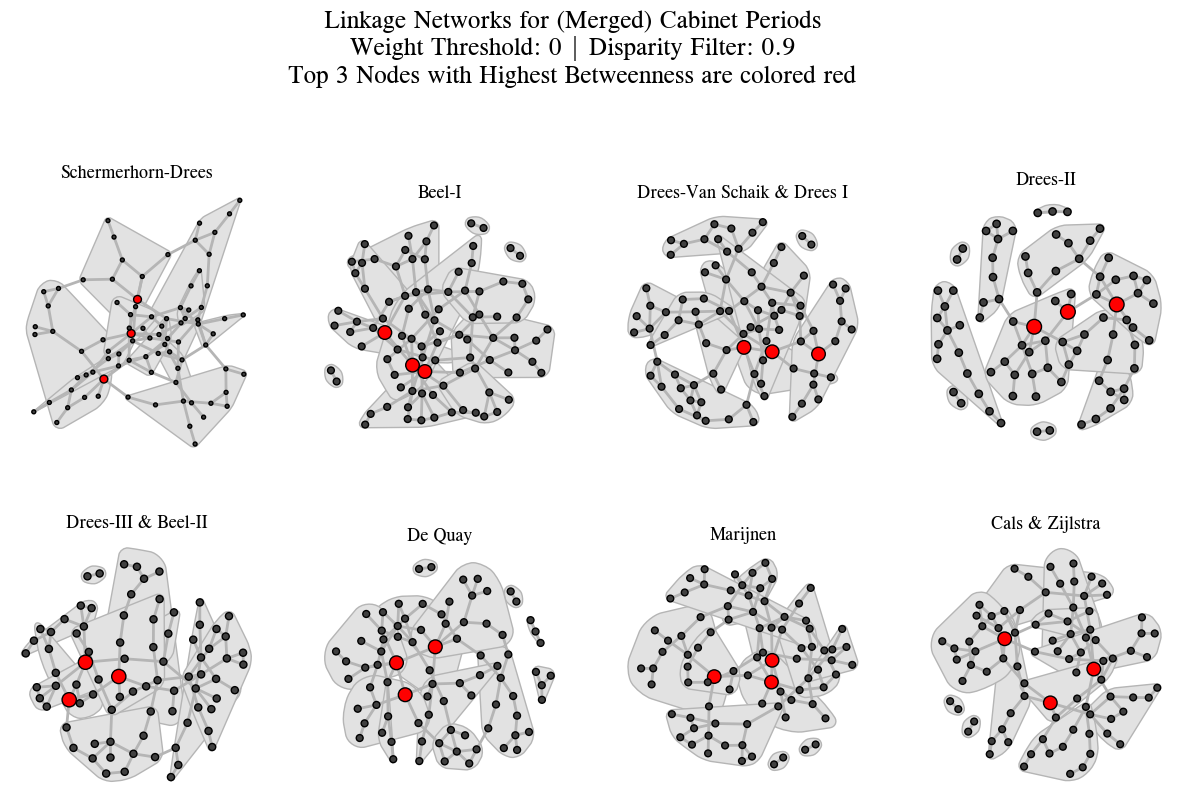

In [3]:
fig = plt.figure(figsize=(15,8))

for c,(i,r) in enumerate(cab_.iterrows()):
    mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
    dist_subset = dists.loc[mask].to_numpy()
    ax = plt.subplot(2, 4, c + 1)
    nvz.plot_network(dists_subset=dist_subset,
                 ax=ax,
                 labels=labels,
                 weight_threshold=0,
                 df_filter=.91,
                 title=r['cabinet'],
                 show_labels=False)

fig = plt.gcf()
fig.suptitle("Linkage Networks for (Merged) Cabinet Periods\nWeight Threshold: 0 | Disparity Filter: 0.9\nTop 3 Nodes with Highest Betweenness are colored red", fontsize=18,y=1.1)
# plt.savefig('figs/networks-cabinets-filters.pdf',dpi=250)
plt.subplots_adjust(hspace=.25)
plt.show()

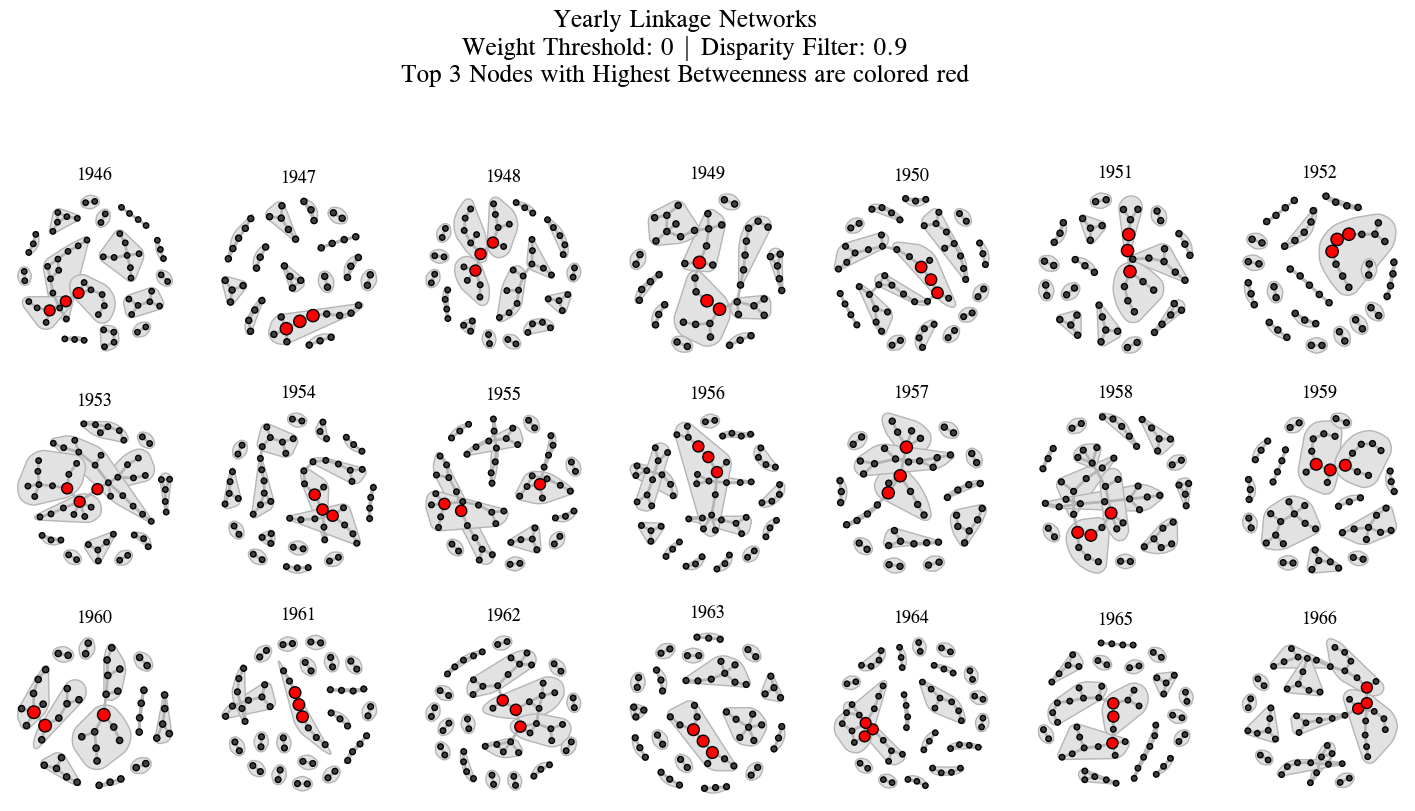

In [8]:
fig = plt.figure(figsize=(18,8))

for c,(year,dist_subset) in enumerate(dists.groupby(dists.index.to_period('Y'))):
    ax = plt.subplot(3, 7, c + 1)
    nvz.plot_network(dists_subset=dist_subset.to_numpy(),
                 ax=ax,
                 labels=labels,
                 weight_threshold=0,
                 df_filter=0.95,
                 title=str(year),
                 show_labels=False)

fig = plt.gcf()
fig.suptitle("Yearly Linkage Networks\nWeight Threshold: 0 | Disparity Filter: 0.9\nTop 3 Nodes with Highest Betweenness are colored red", fontsize=18,y=1.1)
# plt.savefig('figs/networks-years-filters.pdf',dpi=250)
plt.subplots_adjust(hspace=.25)
plt.show()

In [128]:
r = []
for c,(year,dist_subset) in enumerate(dists.groupby(dists.index.to_period('Q'))):
    g,comm,edge_df = get_network_from_mi_theta(mi_theta=dist_subset.to_numpy(),weight_threshold=0,dis_filter=.75,labels=labels,node_text='labels')
    btw = dict(get_betweenness_values(g))
    deg = dict(get_degree_values(g))
    res = [{"top":l,"btw":btw[l],"deg":deg[l],"date":year} for l in btw]
    r += res

In [129]:
rd = pd.DataFrame(r)
rd = rd[['top','deg','date']].pivot(index='date',columns='top',values='deg').fillna(0.0)
dg = dists.groupby(dists.index.to_period('Q')).mean()

In [130]:
rda = rd.to_numpy()
rda = pd.DataFrame(np.apply_along_axis(zscore,0,rda),index=rd.index,columns=rd.columns)

In [142]:
rda.max(axis=0).reset_index().sort_values(0,ascending=False).head(25)

,top,0
37,land consolidation,7.393488
56,proc-13,7.030886
69,rents,6.781277
47,pbo,6.712577
13,credit markets,6.639146
27,government spending,6.558743
9,coalition politics,6.349193
0,agricultural prices,6.327406
18,education,6.234818
89,social benefits,6.187657


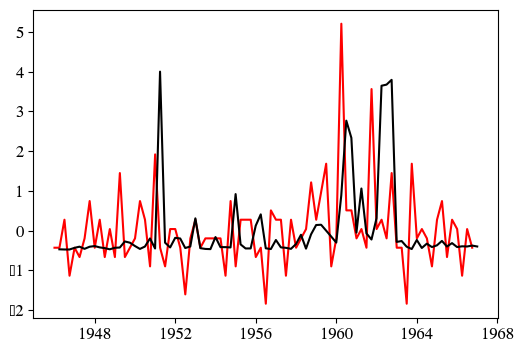

In [144]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
lb = 'new guinea'
ax.plot(rda.index.to_timestamp(),rda[lb],color='red')
ax.plot(dg.index,zscore(dg[[k for k,v in labels.items() if v == lb][0]]),color='black')

In [141]:
words[[k for k,v in labels.items() if v == 'proc-13'][0]]

'kamer adres commissie lid volgen verslag verzoek griffie loterij algemeen belang wetsontwerp inzage voorstellen houdende overwegen hand sgravenhage conclusie beraadslaging '

<AxesSubplot: xlabel='date'>

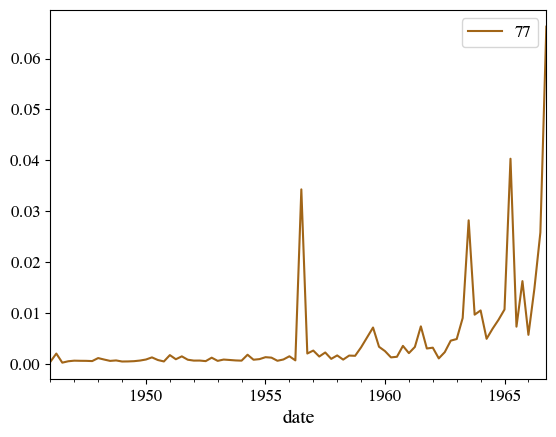

In [122]:
dg.reset_index().plot(x='date',y=[k for k,v in labels.items() if v == 'coalition politics'][0])